In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
path = "D:/lecture/研一上学期/统计基础/Final_Project/PRSA.csv"
data = pd.read_csv(path)

# 将时间变量作为index
index = pd.date_range('2010-01-01', periods=43824, freq='H')
# del data['year']
data = data.set_index(index)

# 缺失值统计
print("缺失值统计：", data.isnull().sum())
# 有缺失值，用前值填充, 所以
data.fillna(method = 'ffill', inplace=True)
print(data.shape)
data = data.dropna()
print(data.shape)

# 将cbwd转为种类变量 0-3四种方向
data['cbwd_cat']=pd.Categorical(data.cbwd).codes

# 变量处理
# 删除year,month,day,hour（因为已经生成了对应的时间戳作为index
del data['year'], data['day'], data['hour'], data['month'], data['No'], data['cbwd']

缺失值统计： No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64
(43824, 13)
(43800, 13)


In [13]:
data.describe()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_cat
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,97.784018,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,1.663516
std,91.398542,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247,0.938032
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,1.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,2.000000
75%,136.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,2.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000,3.000000


pm2.5       float64
DEWP          int64
TEMP        float64
PRES        float64
Iws         float64
Is            int64
Ir            int64
cbwd_cat       int8
dtype: object


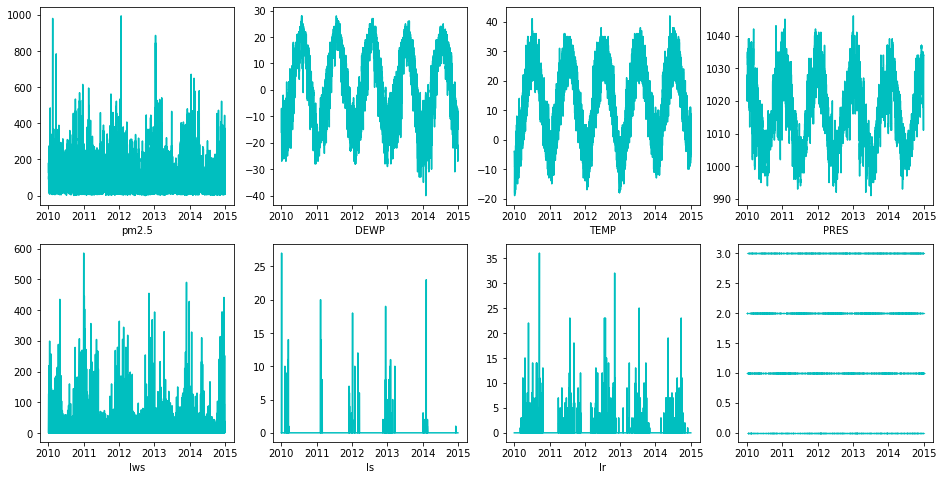

In [38]:
# 描述统计部分
# 各变量类型
print(data.dtypes)
# 可视化各变量数据
fig = plt.figure(figsize=(16,8))
sublist = [241,242,243,244,245,246,247,248]
inx = 1
for i in data.columns:
    plt.subplot(sublist[inx-1])
    inx = inx+1
    if i == 'cbwd_cat':
        plt.scatter(data.index,data['cbwd_cat'] ,color='c', s=0.01)
        break

    plt.plot(data.index, data[i],color='c')
    plt.xlabel(i)

fig.savefig('D:/Latex_Project/Statistics_Project/Figures/var_plot.jpg')

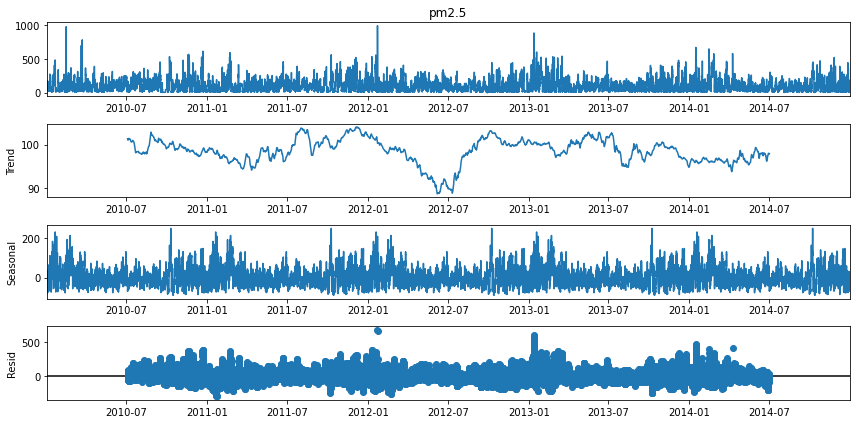

         lb_stat  lb_pvalue
1   40802.280877        0.0
2   77762.129770        0.0
3  111251.689843        0.0
4  141732.442287        0.0
5  169451.160133        0.0
6  194659.248556        0.0


In [8]:
# 为了能够进行季节性因素分解，因为数据存在变量值为0的点，将其赋值为0.00001以便分解
data = data.replace(0,0.00001)
data = data[:]

# 2*24的移动平均
rolling = data['pm2.5'].rolling(window=24)
rolling_mean = rolling.mean()
 
# 再用季节因素分解
result2=seasonal_decompose(data['pm2.5'], model='add', period=24*365)
plt.rcParams["figure.figsize"] = (12,6)
result2.plot()
fig.savefig('D:/Latex_Project/Statistics_Project/Figures/seasonal_decompose.jpg')
plt.show()

# 对残差进行白噪声检验
resid = result2.observed-result2.seasonal

print(acorr_ljungbox(resid, lags=6)) 
# 结果均为显著，说明不是残差序列不是白噪声序列，进一步对其进行ARIMA模型拟合，提取其自相关和累积相关关系

ARIMA部分

原始序列的检验结果为： (-25.06537943534473, 0.0, 27, 43772, {'1%': -3.430499403352111, '5%': -2.8616060330062463, '10%': -2.5668051472213618}, 391690.00825233955)


D:\applications\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


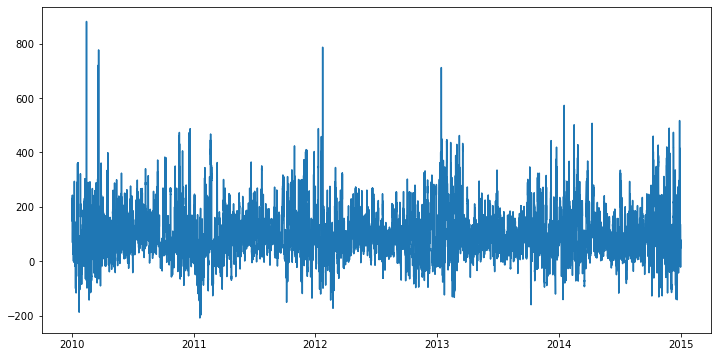

<Figure size 72x432 with 0 Axes>

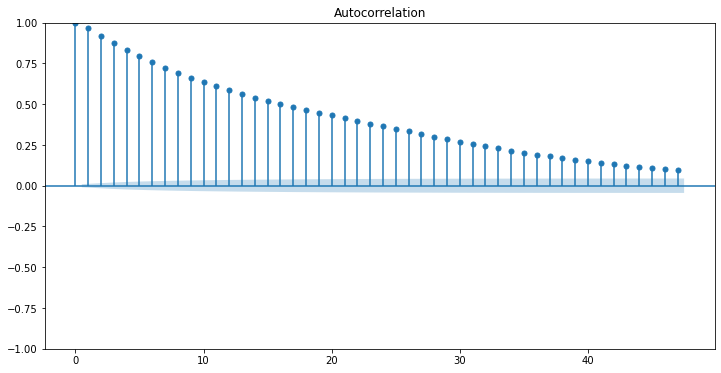

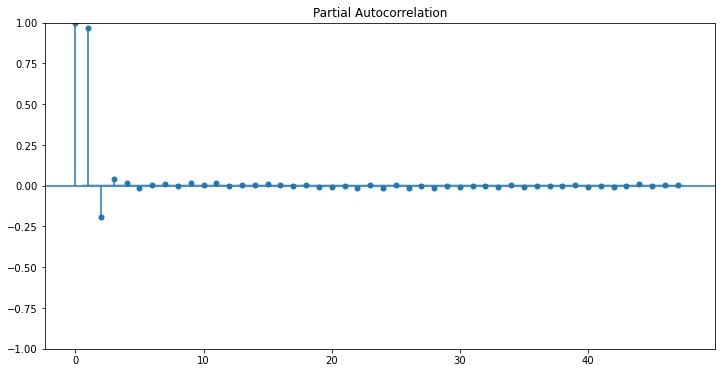

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#平稳性检测
from statsmodels.tsa.stattools import adfuller
plt.plot(resid)
# ADF检验平稳性
print('原始序列的检验结果为：',adfuller(resid))
# 图看出大概也是平稳的,且ADF检验p值小于0.05，可以认为是平稳序列

# resid的ACF & PACF
fig = plt.figure(figsize=(1,6))
plot_acf(resid)
plot_pacf(resid)
# plt.show()
fig.savefig('D:/Latex_Project/Statistics_Project/Figures/acf_pacf.jpg')

In [27]:
# AIC,BIC定阶
from statsmodels.tsa.arima.model import ARIMA
# ARIMA(resid, order=(2,0,0)).fit()
pmax = 3
qmax = 3
aic_matrix = []
bic_matrix = []
for p in range(pmax):
    tempaic= []
    tempbic= []
    for q in range(qmax):
        try:
            tempaic.append(ARIMA(resid, order=(p+1, 0, q+1)).fit().aic)
            tempbic.append(ARIMA(resid, order=(p+1, 0, q+1)).fit().bic)
        except:
            tempaic.append(None)
            tempbic.append(None)
    aic_matrix.append(tempaic)
    bic_matrix.append(tempbic)

In [28]:
aic_table = pd.DataFrame(aic_matrix)   #将其转换成Dataframe 数据结构
p,q = aic_table.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'AIC 最小的p值 和 q 值：%s,%s' %(p+1,q+1))  #  AIC 最小的p值 和 q 值：0,1
print(aic_table)

bic_table = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
p,q = bic_table.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p+1,q+1))  #  BIC 最小的p值 和 q 值：0,1
bic_table

AIC 最小的p值 和 q 值：1,3
               0              1              2
0  392250.878411  392248.639606  392209.860256
1  392249.661323  392234.804039  392211.320108
2  392226.698819  392210.152221  392211.693602
BIC 最小的p值 和 q 值：1,3


,0,1,2
0,392285.627967,392292.076552,392261.984591
1,392293.098268,392286.928374,392272.131832
2,392278.823154,392270.963945,392281.192715


    lb_stat  lb_pvalue
1  0.000083   0.992738
2  0.000083   0.999958
3  0.073823   0.994782
4  0.862386   0.929894
5  0.862676   0.972865
6  6.691459   0.350325


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                43800
Model:                 ARIMA(1, 0, 3)   Log Likelihood             -196098.930
Date:                Sun, 25 Dec 2022   AIC                         392209.860
Time:                        03:09:22   BIC                         392261.985
Sample:                    01-02-2010   HQIC                        392226.289
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         97.7840      2.988     32.728      0.000      91.928     103.640
ar.L1          0.9541      0.001    779.237      0.000       0.952       0.957
ma.L1          0.2006      0.002    103.405      0.000       0.197       0.204
ma.L2          0.0011      0.002      0.617      0.537      -0.002       0.005
ma.L3         -0.0324      0.002    -16.062      0.000      -0.036      -0.028
sigma2       453.2235      0.565    802.471      0.000     452.117     454.330
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           9424187.93
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        74.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

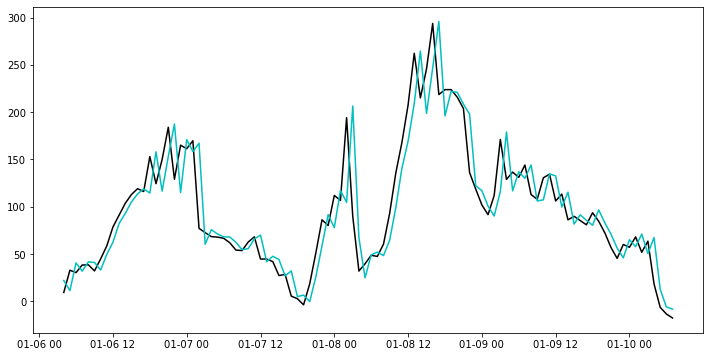

In [31]:
# 拟合ARMA(1,3)模型
model = ARIMA(resid, order=(1, 0, 3))
model_fit = model.fit()

# 因为数据太多，截取部分数据观察拟合效果
predictions = model_fit.predict()
plt.plot(resid[100:200],color='black')
plt.plot(predictions[100:200], color='c')
# 但拟合效果并不怎么理想，有明显的滞后情况

# 对残差进行白噪声检验
print(acorr_ljungbox(model_fit.resid, lags=6))
# 此时残差已经几乎是白噪声了
model_fit.summary()

回归部分  


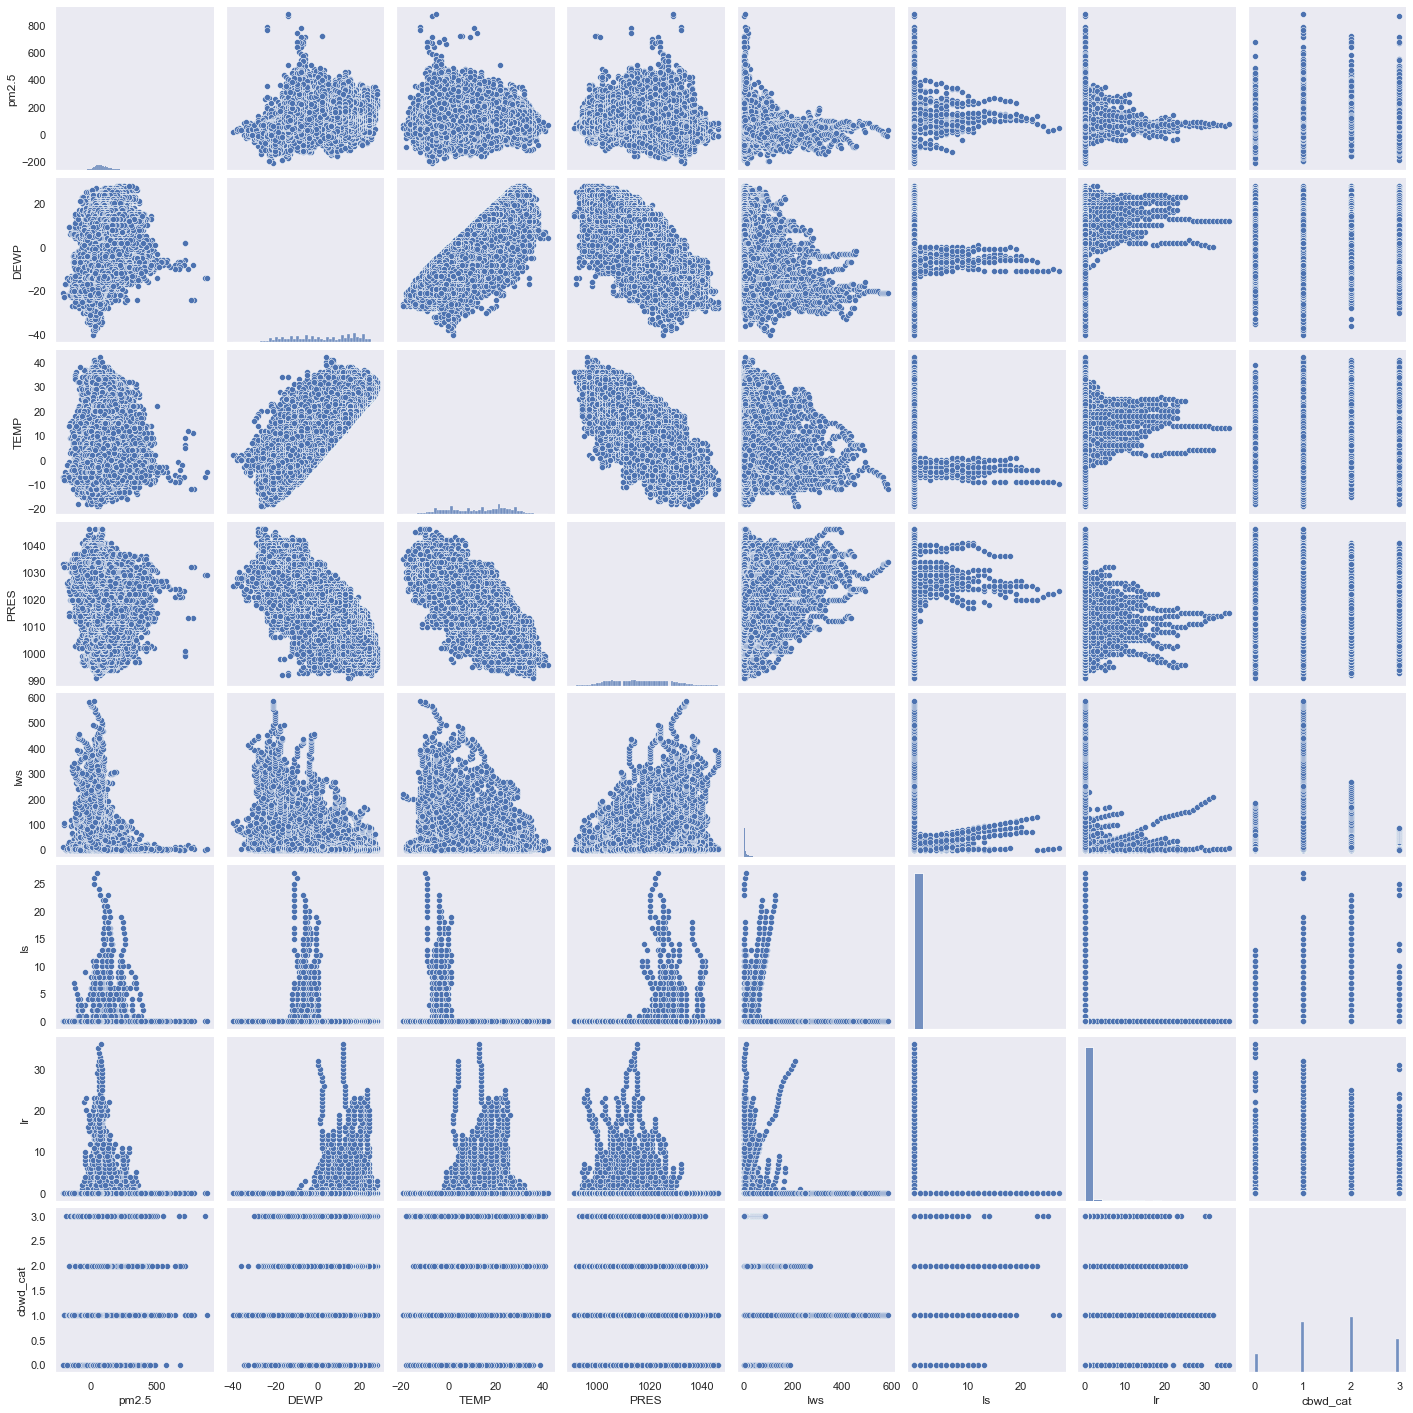

     VIF Factor  features
0  34655.111660     const
1      3.903416      DEWP
2      4.473352      TEMP
3      3.493725      PRES
4      1.152458       Iws
5      1.016078        Is
6      1.034782        Ir
7      1.085914  cbwd_cat


In [21]:
# 变量相关性检验
import seaborn as sns

sns.set(style='dark', context='notebook') 
sns.pairplot(data)
plt.savefig("D:/Latex_Project/Statistics_Project/Figures/var_corr.jpg")
plt.show()

# 部分变量存在线性关系，检查多重共线性问题
# 多重共线性检验  
# 方差膨胀因子检验多重共线性  
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
def vif(data):
    features = ['DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_cat']
    labels = ['pm2.5']
    Y = data[labels]
#     加入常量变量
    X = sm.add_constant(data[features])
    vif = pd.DataFrame()
    vif["VIF Factor"]=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif["features"]=X.columns
    print(vif)

vif(data)
# vif在5以下，认为没有多重共线性，可以进行OLS模型拟合

In [22]:
# 分析线性回归  
import statsmodels.api as sm

def linearModel(data):
    features = ['DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_cat']
    labels = ['pm2.5']
    Y = data[labels]
#     加入常量变量
    X = sm.add_constant(data[features])
#     构建模型
    re = trainModel(X, Y)
#     分析模型效果
    modelSummary(re)
    
def trainModel(X, Y):
    model = sm.OLS(Y, X)
    re = model.fit()
    return re

def modelSummary(re):
    print("整体统计分析结果",re.summary())
    
    coef_df = pd.DataFrame({"params": re.params,   # 回归系数
                        "std err": re.bse,     # 回归系数标准差
                        "t": round(re.tvalues,3),       # 回归系数T值
                        "p-values": round(re.pvalues,3) # 回归系数P值
                         })

    coef_df[['coef_0.025','coef_0.975']] = re.conf_int() # 回归系数置信区间 默认5%，括号中可填具体数字 比如0.05, 0.1
    print(coef_df)
    
trainnum = int(data.shape[0]*0.80)
df_train = data.iloc[0:trainnum,:]
df_test = data.iloc[trainnum:,:]
linearModel(df_train)
# 从模型拟合结果来看，虽然变量系数均显著，但R^2较小，拟合效果可能一般，接下来拟合预测效果

整体统计分析结果                             OLS Regression Results                            
Dep. Variable:                  pm2.5   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     1055.
Date:                Mon, 26 Dec 2022   Prob (F-statistic):               0.00
Time:                        06:13:45   Log-Likelihood:            -2.0062e+05
No. Observations:               35040   AIC:                         4.012e+05
Df Residuals:                   35032   BIC:                         4.013e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1576.7569     72.275     21.816

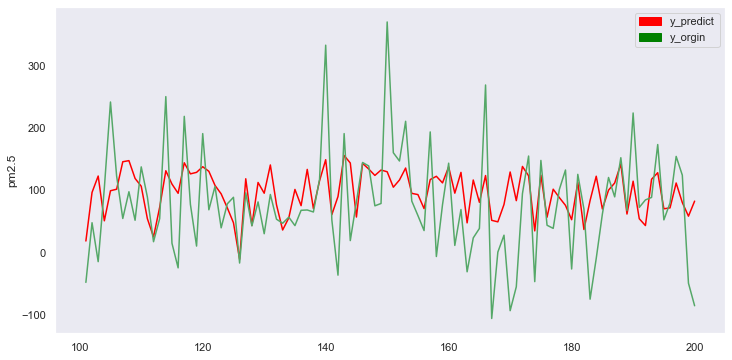

Test Statistic                  -187.044154
p-value                            0.000000
Lags Used                          0.000000
Number of Observations Used    35039.000000
dtype: float64


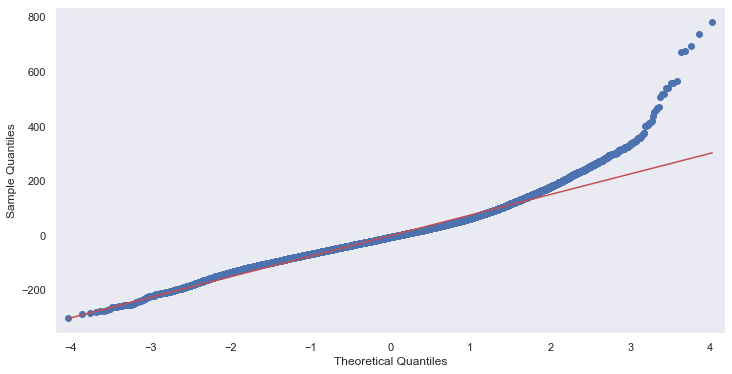

In [24]:
# 模型预测结果展示(将数据随机分为训练集和测试集,按8:2)  
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
from statsmodels.graphics.gofplots import qqplot

def plot_predict(data,pred_range):
    features = ['DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_cat']
    labels = ['pm2.5']
    Y = data[labels]
#     加入常量变量
    X = sm.add_constant(data[features])
#     构建模型
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)
    
    re = trainModel(X_train, Y_train)
    
    Y_predict = re.predict(X_test)
    index = list(np.linspace(1,len(Y_predict),len(Y_predict)))
    color=['red','green']
    labels = ['y_predict', 'y_orgin']  #legend标签列表
    #用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
    patches = [mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 
    
    plt.plot(index[100:200],Y_predict[100:200],color='red')
#     plt.legend("Y_predict")
    plt.plot(index[100:200], Y_test['pm2.5'][100:200], color='g')
    plt.legend(handles=patches)
    plt.ylabel("pm2.5")
    
    plt.savefig("D:/Latex_Project/Statistics_Project/Figures/predict.jpg")
    plt.show()
    
#     残差QQ图检验正态性
    qqplot(re.resid, line='s')
    plt.savefig("D:/Latex_Project/Statistics_Project/Figures/qq.jpg")
    
#     协整检验，这里和后面ARIMAX要用
    ad = sm.tsa.adfuller(re.resid,autolag='BIC')
    ad_output = pd.Series(ad[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    print(ad_output)
    
pred_range = [100,200]
plot_predict(data, pred_range)
# 拟合效果也一般。
# QQ图也不太像正态

ARIMAX

In [105]:
# 协整检验
# 做成一个表格，变量名和P值

# 或者不用协整直接检查各变量平稳性  
# 因为ARIMAX(p,i,q)要求所有的序列的是平稳的，所以要对序列进行单位根检验，判断序列的平稳性。
## 1:单位根检验检验序列的平稳性,ADF 检验
data_pm25 = sm.tsa.adfuller(data['pm2.5'],autolag='BIC')
data_pm25_output = pd.Series(data_pm25[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("pm2.5 检验结果：")
# print(data_pm25_output)

data_DEWP = sm.tsa.adfuller(data['DEWP'],autolag='BIC')
data_DEWP_output = pd.Series(data_DEWP[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("DEWP 检验结果：")
# print(data_DEWP_output)

data_TEMP = sm.tsa.adfuller(data['TEMP'],autolag='BIC')
data_TEMP_output = pd.Series(data_TEMP[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("TEMP 检验结果：")
# print(data_TEMP_output)

data_PRES = sm.tsa.adfuller(data['PRES'],autolag='BIC')
data_PRES_output = pd.Series(data_PRES[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("PRES 检验结果：")
# print(data_PRES_output)

data_Iws = sm.tsa.adfuller(data['Iws'],autolag='BIC')
data_Iws_output = pd.Series(data_Iws[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("Iws 检验结果：")
# print(data_Iws_output)

data_Is = sm.tsa.adfuller(data['Is'],autolag='BIC')
data_Is_output = pd.Series(data_Is[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("Is 检验结果：")
# print(data_Is_output)

data_Ir = sm.tsa.adfuller(data['Ir'],autolag='BIC')
data_Ir_output = pd.Series(data_Ir[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("Ir 检验结果：")
# print(data_Ir_output)

data_cbwd_cat = sm.tsa.adfuller(data['cbwd_cat'],autolag='BIC')
data_cbwd_cat_output = pd.Series(data_cbwd_cat[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
# print("cbwd_cat 检验结果：")
# print(data_cbwd_cat_output)

dic = {'pm2.5':data_pm25_output, 'DEWP':data_DEWP_output,'TEMP':data_TEMP_output,'PRES':data_PRES_output,'Iws':data_Iws_output,
       'Is':data_Is_output,'Ir':data_Ir_output,'cbwd_cat':data_cbwd_cat_output}

dic=pd.DataFrame(dic)
dic

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_cat
Test Statistic,-32.534557,-6.220273e+00,-3.938179,-7.392936e+00,-34.100307,-46.786133,-48.221079,-50.075072
p-value,0.000000,5.243935e-08,0.001771,7.913245e-11,0.000000,0.000000,0.000000,0.000000
Lags Used,2.000000,4.200000e+01,49.000000,5.500000e+01,2.000000,5.000000,0.000000,7.000000
Number of Observations Used,43797.000000,4.375700e+04,43750.000000,4.374400e+04,43797.000000,43794.000000,43799.000000,43792.000000


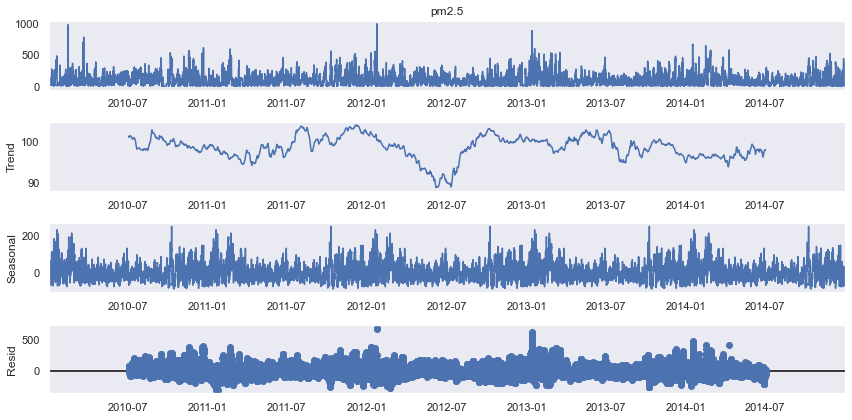

In [17]:
# 模型预设
result2=seasonal_decompose(data['pm2.5'], model='add', period=24*365)
plt.rcParams["figure.figsize"] = (12,6)
result2.plot()
# fig.savefig('D:/Latex_Project/Statistics_Project/Figures/seasonal_decompose.jpg')
plt.show()

data['pm2.5'] = result2.observed-result2.seasonal  #重新赋值

endog = data['pm2.5'][:]
exog = sm.add_constant(data[['DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_cat']][:])

In [18]:
# AIC,BIC定阶
# df
pmax = 4
qmax = 4
aic_matrix = []
bic_matrix = []

for p in range(pmax):
    tempaic= []
    tempbic= []
    
    for q in range(qmax):
        try:
            tempaic.append(sm.tsa.statespace.SARIMAX(endog, exog, order=(p,0,q)).fit().aic)
            tempbic.append(sm.tsa.statespace.SARIMAX(endog, exog, order=(p,0,q)).fit().bic)
        except:
            tempaic.append(None)
            tempbic.append(None)
    aic_matrix.append(tempaic)
    bic_matrix.append(tempbic)

aic_table = pd.DataFrame(aic_matrix)   #将其转换成Dataframe 数据结构
p,q = aic_table.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'AIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  AIC 最小的p值 和 q 值：0,1
print(aic_table)

bic_table = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
p,q = bic_table.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1
bic_table

D:\applications\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\applications\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\applications\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\applications\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\applications\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

AIC 最小的p值 和 q 值：1,3
               0              1              2              3
0  503053.667006  458030.185125  432289.997590  418542.473281
1  393325.262228  391938.914330  391941.871333  391886.073735
2  392006.325951  391944.660851  392430.323292  391928.614874
3  391919.343502  393058.805862  391923.256758  391945.095617
BIC 最小的p值 和 q 值：1,3


,0,1,2,3
0,503131.853508,458117.059016,432385.558870,418646.721950
1,393412.136119,392034.475610,392046.120002,391999.009793
2,392101.887231,392048.909520,392543.259350,392050.238321
3,392023.592171,393171.741921,392044.880205,392075.406454


In [19]:
# 定（1，0，3）
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1, 0, 3))
res = mod.fit(disp=False)
print(res.summary())

D:\applications\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  pm2.5   No. Observations:                43800
Model:               SARIMAX(1, 0, 3)   Log Likelihood             -195930.037
Date:                Mon, 26 Dec 2022   AIC                         391886.074
Time:                        05:05:27   BIC                         391999.010
Sample:                    01-02-2010   HQIC                        391921.669
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1603.8758    134.703     11.907      0.000    1339.862    1867.889
DEWP           1.0398      0.058     17.921      0.000       0.926       1.153
TEMP          -0.3469      0.064     -5.442      0.0

In [20]:
# 残差LB检验
print(acorr_ljungbox(res.resid, lags=6))

     lb_stat  lb_pvalue
1   0.035392   0.850776
2   0.065627   0.967719
3   0.079288   0.994201
4   0.298845   0.989889
5   1.234748   0.941501
6  11.989339   0.062207
